Užduotis: https://trokas.github.io/ai_primer/Flatland.html

# Duomenys

Duomenų įkėlimas

In [25]:
path_to_flatland_train_data = '/content/flatland_train.data'
path_to_flatland_test_data = '/content/flatland_test.data'

import pickle, gzip

X_train, y_train = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
X_eval, y_eval = pickle.load(gzip.open(path_to_flatland_test_data, 'rb'))

# Duomenu peržiūra

Peržiūrome turimus duomenis

In [ ]:
print("X_train shape:", X_train.shape)
print("Total elements in X_train:", X_train.size)
print("X_train data type:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("Total elements in y_train:", y_train.size)
print("y_train data type:", y_train.dtype)

X_train shape: (10000, 50, 50)
Total elements in X_train: 25000000
X_train data type: float64
y_train shape: (10000,)
Total elements in y_train: 10000
y_train data type: float64


In [ ]:
import numpy as np

print(y_train[:10])
print(np.min(y_train), np.max(y_train))  # Check the min and max of the labels
print(np.unique(y_train))  # Show unique values in y_train

unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value {value}: {count} occurrences")

[4. 6. 5. 4. 3. 3. 4. 4. 6. 0.]
0.0 6.0
[0. 3. 4. 5. 6.]
Value 0.0: 1381 occurrences
Value 3.0: 2853 occurrences
Value 4.0: 1868 occurrences
Value 5.0: 2137 occurrences
Value 6.0: 1761 occurrences


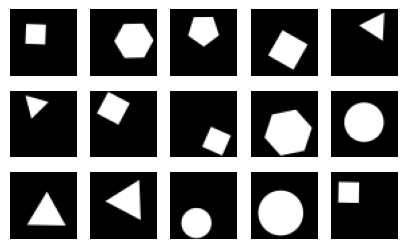

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
for i in range(15):
  plt.subplot (3,5, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.axis('off')
plt.show()

# Duomenų apdorojimas

Figūrų labels paverčiam į integers, ir pakeičiam jų mapping

In [26]:
import numpy as np

y_train = y_train.astype(int)

y_train[y_train != 0] -= 2    # Correct labels so that triangle is mapped to class 1
print(np.unique(y_train))  # Show unique values in y_train

[0 1 2 3 4]


In [27]:
import torch

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

Figūras sucentruojame, kad būtų paveiksliuko centre ir maždaug suvienodinam jų dydį.

In [28]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import random

def augment_with_scaling(X_train, min_scale=0.5, max_scale=2.0):
    # Add channel dimension if not present
    if len(X_train.shape) == 3:
        X_train = X_train.unsqueeze(1)

    augmented = torch.zeros_like(X_train)

    for i in range(len(X_train)):
        # Find the actual shape boundaries
        nonzero = torch.nonzero(X_train[i].squeeze())
        if len(nonzero) > 0:
            y_min, x_min = nonzero.min(0)[0]
            y_max, x_max = nonzero.max(0)[0]

            # Calculate current shape size
            height = y_max - y_min + 1
            width = x_max - x_min + 1
            max_dim = max(height, width)

            min_size = 20

            # Calculate safe scale factor to ensure shape fits
            #max_safe_scale = min(45 / max_dim, max_scale)  # Leave some padding
            #scale = random.uniform(min_scale, max_safe_scale)
                        # Ensure shape has at least min_size after scaling
            if max_dim < min_size:
                scale = min_size / max_dim
            else:
                max_safe_scale = min(45 / max_dim, max_scale)  # Leave some padding
                scale = random.uniform(min_scale, max_safe_scale)


            # Extract and scale the shape
            shape = X_train[i, :, y_min:y_max+1, x_min:x_max+1]
            new_size = int(max_dim * scale)
            #resized = transforms.Resize((new_size, new_size))(shape)
            resized = F.interpolate(shape.unsqueeze(0), size=(new_size, new_size), mode='bilinear', align_corners=False).squeeze(0)
            # Center in the 50x50 frame
            y_start = (50 - new_size) // 2
            x_start = (50 - new_size) // 2
            augmented[i, :, y_start:y_start + new_size, x_start:x_start + new_size] = resized
        else:
            augmented[i] = X_train[i]  # Copy original if no shape found

    return augmented

# Use the function
X_train = augment_with_scaling(X_train, min_scale=0.5, max_scale=2)

Turime tokį duomenų pasiskirstymą:
  

*   Value 0.0: 1381 occurrences
*   Value 3.0: 2853 occurrences
*   Value 4.0: 1868 occurrences
*   Value 5.0: 2137 occurrences
*   Value 6.0: 1761 occurrences

Suvienodinam turimų paveiksliukų kiekį, kad modelis neturėtų bias daugumos klasei.
Sintetinius duomenis gauname pasukdami, paversdami, pakeičiant dydį turimų figūrų.

In [29]:
import torch
from torchvision import transforms
import random

# Define augmentations
augment = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(50, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

def augment_class(X_train, y_train, target_class, n_samples):
    """Generate synthetic samples for a specific class to reach n_samples."""
    class_indices = (y_train == target_class).nonzero(as_tuple=True)[0]
    synthetic_samples = []
    synthetic_labels = []

    while len(synthetic_samples) < n_samples:
        idx = random.choice(class_indices)
        sample = X_train[idx].unsqueeze(0)  # Add batch dimension
        augmented_sample = augment(sample)
        synthetic_samples.append(augmented_sample)
        synthetic_labels.append(torch.tensor(target_class))

    synthetic_samples = torch.cat(synthetic_samples[:n_samples - len(class_indices)])
    synthetic_labels = torch.stack(synthetic_labels[:n_samples - len(class_indices)])
    return synthetic_samples, synthetic_labels

# Get the number of samples in the majority class
class_counts = torch.bincount(y_train.int())
max_count = class_counts.max().item()

# Augment each class to match the majority class count
balanced_X = []
balanced_y = []

for target_class in range(len(class_counts)):
    class_indices = (y_train == target_class).nonzero(as_tuple=True)[0]
    X_class = X_train[class_indices]
    y_class = y_train[class_indices]

    # Add original samples
    balanced_X.append(X_class)
    balanced_y.append(y_class)

    # Generate synthetic samples if needed
    if len(class_indices) < max_count:
        synthetic_X, synthetic_y = augment_class(X_train, y_train, target_class, max_count)
        balanced_X.append(synthetic_X)
        balanced_y.append(synthetic_y)

# Combine all balanced data
X_train_balanced = torch.cat(balanced_X)
y_train_balanced = torch.cat(balanced_y)

# Shuffle the balanced dataset
perm = torch.randperm(X_train_balanced.size(0))
X_train_balanced = X_train_balanced[perm]
y_train_balanced = y_train_balanced[perm]

print("Balanced class distribution:", torch.bincount(y_train_balanced.int()))

X_train = X_train_balanced
y_train = y_train_balanced

Balanced class distribution: tensor([2853, 2853, 2853, 2853, 2853])


Sobel filtras. Nenaudoti

In [41]:
import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'




# Define Sobel filters for x and y directions
sobel_x = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]]).reshape(1, 1, 3, 3)

sobel_y = torch.tensor([[-1., -2., -1.],
                        [0., 0., 0.],
                        [1., 2., 1.]]).reshape(1, 1, 3, 3)

sobel_x, sobel_y = sobel_x.to(device), sobel_y.to(device)


def apply_sobel_filter(images):
    # Ensure images are on the same device as the Sobel filters
    images = images.to(device)

    #images = images.squeeze(2)
    images = images.unsqueeze(1)

    # Apply Sobel filter in x and y directions
    grad_x = F.conv2d(images, sobel_x, padding = 1)
    grad_y = F.conv2d(images, sobel_y, padding = 1)

    # Calculate gradient magnitude
    gradient_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

    # Normalize to range [0, 1] (optional)
    gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())

    return gradient_magnitude

X_train = apply_sobel_filter(X_train)


Random paveiksliukai po duomenų apdorojimo

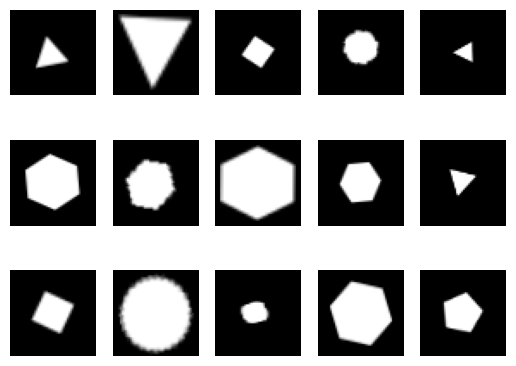

In [30]:
import matplotlib.pyplot as plt
import random

def show_random_image(images):

    # Get the random image
    for i in range(15):
      random_index = random.randint(0, images.shape[0] - 1)
      image = images[random_index]


      image = image.squeeze(0)

      # Convert the image to numpy array and display
      image_np = image.cpu().detach().numpy()  # Move to CPU and convert to NumPy
      plt.subplot (3,5, i+1)
      plt.imshow(image_np, cmap='gray')
      plt.axis('off')


show_random_image(X_train)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [32]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

# Modelio treniravimas

CNN modelis

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

# Define the CNN Model
class ShapeCornerCNN(nn.Module):
    def __init__(self):
        super(ShapeCornerCNN, self).__init__()

        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )

        # Calculate the size after convolutions
        self.flatten_size = 128 * 6 * 6  # For 50x50 input

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # 5 classes for different numbers of corners
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.flatten_size)
        x = self.classifier(x)
        return x

In [34]:
import torch.optim as optim

#model = CornerClassifierCNN(output_size=5)
model = ShapeCornerCNN()
#model = SmallNet().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adadelta(model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()  # Set to training mode
    running_loss = 0.0

    for images, labels in train_loader:
      # Ensure images have 1 channel
        images = images.view(-1, 1, 50, 50)  # Adjust to 1 channel and 50x50 dimensions

        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print loss per epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.6138
Epoch 2/10, Loss: 0.1918
Epoch 3/10, Loss: 0.1693
Epoch 4/10, Loss: 0.1542
Epoch 5/10, Loss: 0.1528
Epoch 6/10, Loss: 0.1473
Epoch 7/10, Loss: 0.1392
Epoch 8/10, Loss: 0.1322
Epoch 9/10, Loss: 0.1362
Epoch 10/10, Loss: 0.1250


In [35]:

model.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():  # No need to track gradients during testing
    for images, labels in test_loader:
        images, labels = images.to(device).float(), labels.to(device)
        images = images.view(-1, 1, 50, 50)

        # Forward pass
        outputs = model(images)

        # Compute predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")
print (f"Total test images: {total_test}")
print (f"Correct test images: {correct_test}")


Test Accuracy: 98.32%
Total test images: 1427
Correct test images: 1403


# Modelio įvertinimas

Apdorojam evaluation skirtus duomenis ir užkraunam į dataloader

In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_eval = torch.tensor(X_eval, dtype=torch.float32)


#X_eval = apply_sobel_filter(X_eval)
#X_eval = augment_with_scaling(X_eval, min_scale=0.5, max_scale=1.5)
X_eval = augment_with_scaling(X_eval, min_scale=0.5, max_scale=2)


eval_dataset = TensorDataset(X_eval)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=64, shuffle=False)

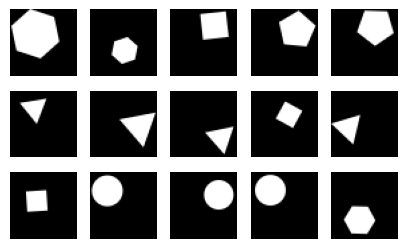

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
for i in range(15):
  plt.subplot (3,5, i+1)
  plt.imshow(X_eval[i], cmap='gray')
  plt.axis('off')
plt.show()

In [37]:

# Make predictions
model.eval()
# List to store predictions
predictions = []

with torch.no_grad():  # Disable gradient tracking
    for batch in eval_loader:  # Assuming eval_loader is your DataLoader for the evaluation set
        images = batch[0]
        images = images.to(device).float()

        # Ensure images have the correct shape
        images = images.view(-1, 1, 50, 50)

        # Forward pass to get predictions
        outputs = model(images)

        # Get the predicted class (rounded to nearest integer, as specified)
        _, predicted_classes = torch.max(outputs, 1)
        predictions.extend(predicted_classes.cpu().numpy())  # Append predictions to the list

predictions = np.array(predictions)

predictions = np.where(predictions != 0, predictions + 2, predictions)
# Convert predictions to the required string format
result = ''.join([str(int(p)) for p in predictions])  # Convert integers to string and join

# Display result or save as needed
print("Predicted output as a single string:", result)

print(f"Length of prediction string: {len(result)}")

with open('predictions.txt', 'w') as f:
    f.write(result)

Predicted output as a single string: 664553334340006334054546564554046305035566033300436336436666406455330365550304335053066460035535546353040336534534504003536065000465553044545554365434504654563563563654630353665636566036030566646353633636333633646535330605356645336045005450006344606034664340045363345644654635450334630034455365505353330644405536344340303060530006465550633456054433005436450044304435064546334606030656430565364504535653333663633066064434550435453606364443366330405554450450534555305066430030344454450403030634400655433340050663654433033403564343434365040333036354343560355646344055064340343045056550530343453665435643503500445306646456603640333046345636440656304355444334535066305356666056453333635033435634435334306033304344343350454643333403663005445054450364360050335563365630055330303303646344446054645343366060560434545653640333003550546406656443055303336534054453063364363565336403003543044035653434406355603303643335456063503644050464006534434036063064565640436363564643540

In [38]:
torch.save(model.state_dict(), "model_weights.pth")
torch.save(model, "model.pth")
